In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses
%matplotlib inline
cuda = True

In [2]:
from data import Calculated

data_manager = Calculated()

In [10]:
num_columns = 36
class HitPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        return self.layers(game_state)

In [11]:
#categories = ['pass_', 'passed', 'dribble', 'dribble_continuation', 'shot', 'goal', 'assist', 'assisted', 'save', 'aerial']
categories = ['pass_', 'shot', 'goal', 'aerial']

def get_train_test_data(proto, dataframe):
    
    # Only from the perspective of the blue team (we'll switch them up)
#     players = dataframe.columns.levels[0]
#     columns = dataframe.columns.levels[1]
    players = proto.players
    teams = proto.teams
    team_map = {}
    for i, team in enumerate(teams):
        for player in team.player_ids:
            team_map[player.id] = int(team.is_orange)
            
    name_map = {}
    for i, player in enumerate(players):
        name_map[player.id.id] = player.name
    
    hits = proto.game_stats.hits
    inputs = []
    outputs = []
    for hit in hits:
        player_name = name_map[hit.player_id.id]
        
        frame = dataframe.iloc[hit.frame_number + 1]
        
        player_location = frame[player_name].fillna(-1)
        ball_location = frame['ball'].fillna(-1)
        input_vector = ball_location.values
        input_vector = np.append(input_vector, player_location.values)
        
        inputs.append(input_vector)
        vector = np.zeros(len(categories))
        for i, c in enumerate(categories):
            if getattr(hit, c):
                vector[i] = 1
        outputs.append(vector)
    inputs = np.array(inputs).astype(float)
    outputs = np.array(outputs)
    rand = np.random.rand(outputs.shape[0])
    threshold = rand < 0.8
    input_train, input_test = inputs[threshold], inputs[~threshold]
    output_train, output_test = outputs[threshold], outputs[~threshold]
    
    return input_train, input_test, output_train, output_test


# loss = nn.BCELoss()
loss = nn.MSELoss()
def train_on_proto_df(proto, df, model):
    input_train, input_test, output_train, output_test = get_train_test_data(proto, df)
    if input_train is None:
        print('data is none')
        return
    input_tensor = torch.from_numpy(input_train).float()
    output_tensor = torch.from_numpy(output_train).float()
    if cuda:
        input_tensor = input_tensor.cuda()
        output_tensor = output_tensor.cuda()
#     print(output_train.shape, output_test.shape)
    print(proto.game_metadata.match_guid)
    for x in range(1000):
        opt.zero_grad()
        predicted = model(input_tensor)
#         print("shapes", predicted.shape, output_tensor.shape)
        loss_val = loss(predicted, output_tensor)
        loss_val.backward()
        opt.step()
        if x % 30 == 0:
#             print(input_tensor.shape, predicted.shape, output_tensor.shape)
#             print('Loss:', loss_val)
            input_test_tensor = torch.from_numpy(input_test).float()
            if cuda:
                input_test_tensor = input_test_tensor.cuda()
            test_output = model(input_test_tensor)
            output = test_output.cpu().detach().numpy()
            accuracy = (output.round() == output_test)
    return loss_val.cpu().data.numpy(), accuracy

In [12]:
model = HitPredictor().train()
if cuda:
    model = model.cuda()
opt = optim.Adam(model.parameters(), lr=1e-4)
epochs = 25
epoch_losses = []
accuracy = []
for epoch in range(epochs):
    epoch_loss = []
    epoch_accuracy = []
    for n in range(5):
        for replay in data_manager.get_replay_list(num=10, page=n + 1):
            df = data_manager.get_pandas(replay)
            proto = data_manager.get_proto(replay)
            if df is None or proto is None:
                continue
            try:
                los, acc = train_on_proto_df(proto, df, model)
            except Exception as e:
                print(e)
                continue
            epoch_loss.append(los)
            epoch_accuracy.append(acc)
    epoch_losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)

27A0999611E8D7C81D9466AC7D913D63
08D7BB5E11E8D7D0DC878ABF1E672A5B
9FE83CBC11E8D7D5222FCFA96404771C
4B28CF1011E8D7D65E19BEA287866E61
6A00240611E8D7D632A219B17A38ECB7
F8D6A96211E8D8111B1CAFA6FD072066
CBF62B2211E8D864208C8BA7736BCBEC
4A91977811E8D87E9DA0C08C42D9ABA0
0B2FF2E011E8D88E07E5EFB9EC8E432E
E505D47411E8D8B31F3CF68C7B43BB89
A4111CEC11E8D8B007E5E087EC8E432E
C2F2C6BE11E8D8B1CCE07788B78C084D
2896277211E8D8B2CA891D8AB66CE599
AA3465F811E8D8B4F36D97AD95A970F4
04B357E011E8D8B63F94C786513C40BD
45B45D2011E8D8BB74F0DEA3B7956A0A
D674C00411E8D8BE208CA4AB736BCBEC
49B41C6A11E8D8BDF916AEB46E3E0D8C
81193BB811E8D953003E1B877E06B85B
BA0854E611E8D952F363888D46B62918
39522B1611E8D956BC1143B2AF19E2AD
D61419F611E8D95FF0ECDEAF6EE3B5AE
8B2B9C5E11E8D962CB192282DEE4DFF5
259FCDD411E8D966D823F08A1C972E74
2785427E11E8D965889B3C84F4BC8AE2
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
F820B33611E8DA01DBCAC488676B6A04
A5A8787211E8DA075589608EF4CBF7D5
4EC9E7B611

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

624C0ECA11E8C7EE3FB998A492002E75
EDCA727E11E8C7EFEF450BB27FA4632F
C8B1F06411E8C7F19F723F93DDB876BB
BFD401C211E8C7F09945B1BFA3A4312F
6A6D85B211E8C7FC9584B8982C9F5CBB
A694BFF411E8C7FE4F670EAA0180EC12
46C0895A11E8C7FE15AB67A17925C4DE
29833F5811E8C7FF60EFDB874B79BA5F
C60C46FC11E8C80030F80192613B6737
75888F3211E8CA633BAA50BB83362FD6
547FAEDC11E8CA64E7E173923191C9C9
C2F0241611E8CA6C15E0D586E1E2E2C4
B40DB2C411E8CA6C47A28CACD253EF33
583E64FA11E8CA6EC11E5EAD5E677929
C75EFC6411E8CA6E574325BA0E97E74B
69E016CA11E8CA7097F0FCB9BA7C9F3F
CCF408F811E8CA6FA12725935CEED59D
E90D7B2C11E8D4258E800C8E8982EB9B
5F8D7BBE11E8CB4106B06CB5CFA29187
single positional indexer is out-of-bounds
0F26997611E8C4DE6F9284B015A8A97B
B999CB8611E8CB45E1F51FA837901B26
49DDF75C11E8CB4730F87192613B6737
06C01EB811E8CB48D42E7C80A9813356
EB50C20011E8CB4B5953B1A060D4B411
675BA87411E8CDCC9BD8A99FB6670E51
93516E0A11E8CB5641B484834097B559
single positional indexer is out-of-bounds
FA0FD5C611E8D25147B6DCBED3AEA3D3
614497AA11E8C59F5BB81B9

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

F0D4A05A11E8EB55B2DB63B32D537FA2
D48A3A4611E8EB5943517DB1459FE61A


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

0D67ADA611E8EB5C558920A0F4CBF7D5
DE956FBE11E8EB5AE1741495F97D88AA
ACF75FC411E8EB5C6CAFF7A05D03616E
2192E05A11E8EB5E1D94A1A77D913D63
B30D69E011E8CD79D67AB0AA78296A08
BA8DAC1011E8CD7A6A557DBA86B9BEA2
A3CB6FD811E8CD7C43F8708F37BB68A4
81CE748811E8CA8FAC1326BFCBF30AF2
6CCB0C6A11E8CD8001F23A9787D06070
2E043E1A11E8CA989A1F299B066AC2C0
7764BF4611E8CA9B36D1239D0FF9EBAE
BA64E57A11E8CA9911E9BA9593B724A9
3017512211E8CA9FD42E10A5A9813356
9FE83CBC11E8D7D5222FCFA96404771C
4B28CF1011E8D7D65E19BEA287866E61
6A00240611E8D7D632A219B17A38ECB7
F8D6A96211E8D8111B1CAFA6FD072066
CBF62B2211E8D864208C8BA7736BCBEC
4A91977811E8D87E9DA0C08C42D9ABA0
0B2FF2E011E8D88E07E5EFB9EC8E432E
single positional indexer is out-of-bounds
51F96F1211E8D898CB1980BDDEE4DFF5
single positional indexer is out-of-bounds
FCD8FAF811E8E129460AA88561C00416
single positional indexer is out-of-bounds
2C10646C11E8E12C1F3C24B27B43BB89
9754DC2A11E8E2D6191F2AB6BD9183D4
5A8B0F2E11E8E2D88424E1AD72A1FFC1
single positional indexer is out-of-bounds
16D

86ACCE1811E8DD9BB57A4CA4E67B0A36
6A754D0211E8DD9F3E140EBE3BE58303
595DC06611E8DDA0DD7C25A4DDD66B27
633236D211E8E154348B05B88FD4C46B
2659F53811E8E1774B9A4D863EC41588
0AC7216411E8E178D67A0E9C78296A08
2D9BF40211E8E18304E524A1C70BA343
903994E011E8E190AC137B92CBF30AF2
A5B8BCA211E8E18A07E590A1EC8E432E
4476CCFC11E8E18C11E9FBB993B724A9
2577F36411E8E18FB8435895531CA76A
10889F7A11E8E1D1B2DB34BB2D537FA2
46F2418E11E8E2023E14C6803BE58303
7E31A75611E8E5C30BA8428680B43590
77133B5411E8E5D4DBCAA884676B6A04
695170FA11E8E5D7A24703A69539603F
BB16E49E11E8E5DF41B403BA4097B559
9780807611E8E5E415AB7B877925C4DE
5344BB8E11E8E5E98424839A72A1FFC1
103B123011E8E5ED99C273995776FF5B
F431EAE811E8E5EFAAB63794AABD8C0B
20BAACA211E8E5FB5589169CF4CBF7D5
5D800B7A11E8E87EC11E8D9A5E677929
958B7E5E11E8E87F15E0799AE1E2E2C4
single positional indexer is out-of-bounds
8B04233011E8E88BAEF41EA158E7A53D
A5B1C2F611E8E88FA64B5FABD39CEC1D
BAE6D1BA11E8E89595841FA42C9F5CBB
85AEDC0611E8E8A20FD7B78E1B760370
BD856A0811E8E8D1DDD38DB46FA86103


B7FC6FC611E8D4C955896892F4CBF7D5
single positional indexer is out-of-bounds
9259FFF411E8C9BBFB9AB5AC4F41F148
2806603211E8C1ACB2DFF98B85912911
966DA3B211E8C1AEF0ECD5B26EE3B5AE
B51C7B9611E8D2873F94A886513C40BD
6654B10411E8C1B117754E9E6D034FCF
982C473E11E8D4E2B2DBADA52D537FA2
95C4377611E8D4E3177598BA6D034FCF
997C8F1E11E7F7D384BBD0BC1A6F09FC
9141C8FA11E8C1B85661A89FB3C35066
99A301BE11E8D4E4E09E6D81A4E06F15
C1E3ECE011E8DEFF6D96D6896EC3989C
A93BCE9E11E8DF029BD842BAB6670E51
994354CC11E8DF10F424B3B3EE4D099D
A71BB2CA11E8DF1429D8AD9D326A0091
831AA9F411E8DF1323239F8430B9C58C
DD8EA6A411E8DF1547A25D8ED253EF33
FFA2FD2C11E8DF2D574331820E97E74B
C9C89D3411E8DF3641B482A74097B559
4841D07011E8DF39E9930F81E1517F09
single positional indexer is out-of-bounds
3437409611E8E9E9445A99926F5EF3F1
CD695DE011E8E9E8AB6D838E42CA4096
D0F1D5D411E8E9EBC23CDD8CCFA9171F
9E7CC63811E8E9EE73BB8D9C48F85957
9B34782A11E8E9F0FF3015B171E2F1B6
9204BB3211E8E9F2460A579261C00416


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

C856200611E8EA0EB57AE698E67B0A36
1028EF7A11E8EA10AC13A3ABCBF30AF2
1B9BF23A11E8CDA506B01DAACFA29187
229F537811E8CDA638634A97893AE1C5
52C37D0411E8CB0DC11EBBA05E677929
4A1839DC11E8CB09D67AF9A378296A08
B22CBA5C11E8CB1384246FAF72A1FFC1
157181D811E8CDA89D2EB79B805781BF
82A4466E11E8CB147B42D1906A3A4A60
9B9720EA11E8CB16E06E9980DF9F6172
52DF280811E8CB15C8453090C5A4EE2F
19D3D31011E8CB1588C0ECA0A264708C
D9BC03BC11E8D98BCBFE47839DA27B6A
5B4D07E411E8D98E805A5582093349D7
DDEFE54E11E8D98FCB19D9B9DEE4DFF5
3A9FDF9C11E8D9901DDC00A1C6C9F973
92E6999C11E8D991B17D3F98B9532C19
single positional indexer is out-of-bounds
1A98073E11E8D994197ECABF84162B4C
650A78E811E8D998DB3BE090555AFE8E
030740A211E8D99A7C94A88B3B5C4973
FC8D4DD011E8D99829BD9AB54E4801B1
9780807611E8E5E415AB7B877925C4DE
5344BB8E11E8E5E98424839A72A1FFC1
103B123011E8E5ED99C273995776FF5B
F431EAE811E8E5EFAAB63794AABD8C0B
20BAACA211E8E5FB5589169CF4CBF7D5
8D1487F611E8E6196CAF3DB65D03616E
809B99CC11E8E61BFC4E32A3FA80569B
8F6AA42611E8E61AE99333B9E1517F09


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

942E9B9611E8EB8ACCE0F096B78C084D
3FC9D7D011E8EBF00C9C678A93EEA1E6
703E5EB211E8EBF11B1C04A2FD072066


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

0C169B0E11E8CF113FBD92A13AC558AA
0604D49011E8CF13C11E77BA5E677929
2E7261E211E8CF16E1F5DB8637901B26
3C6B591411E8CF183CDB9D8A1737A86E
C6E61FFE11E8C719177542986D034FCF
single positional indexer is out-of-bounds
C548867011E8C717F2624C816DBC0BD4
7D890F6411E8C72ECC417FAB6B37926C
D96785F011E8C737039CC592EF58DF76
2AFDE3CC11E8C734B2DF36B885912911
92990F0211E8C97838B7FFB493F5F544
D0E1D37C11E8C97B396D9EAD68244BC6
55C0B2BA11E8D3D78E7B788C85745828
AB5E031611E8D3D84DBE4DB858CF47BE
9212893C11E8C982E63954A6DD4705C1
66C3998611E8D3D9E34518AC47A4972F
6BD2FF1E11E8C9862CC8E0AF2D90E774
655387D011E8D3DB6996C09FEA63DF0F
08DFA15011E8C43B1775E48A6D034FCF
B65AF18411E8CA96396D2DAB68244BC6
1C3F05F411E8C44C7A79F0A210B8E4A9
49B1954211E8C45BF6B265A5705CB0BC
0D69A8FE11E8D2480945BE90C3A4E12F
9CD576C211E8C4698E80F28C8982EB9B
708378C211E8D08902ED78BB49383C02
AA08E9B011E8C468396D189468244BC6
single positional indexer is out-of-bounds
8D713E6A11E8CB57A709D3AB31A9144E
55C0B91811E8CB5817755F956D034FCF
3407A73E11E8CB5BB03AD0A

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

FB2A06E211E8E9D1BB8C76846F90FECE
27D1C64411E8E9D776456793B1A4902F
3F8B843011E8E9D99065DF902ADC5625
92B4068211E8E9E3CCE0B789B78C084D
52A2C45A11E8E9E5F24927BFA76F5C8B
A6B0E6F411E8E9E47A79C48710B8E4A9
single positional indexer is out-of-bounds
3437409611E8E9E9445A99926F5EF3F1
CD695DE011E8E9E8AB6D838E42CA4096
AB5E031611E8D3D84DBE4DB858CF47BE
9212893C11E8C982E63954A6DD4705C1
66C3998611E8D3D9E34518AC47A4972F
6BD2FF1E11E8C9862CC8E0AF2D90E774
655387D011E8D3DB6996C09FEA63DF0F
AAD2E38211E8D49EFC4E2B9CFA80569B
49F9E94211E8D3DC6AFFE0B4B470F79B
70E1762811E8D3DD122F25BB6FD9AA21
B4E5A17811E8D3DD97F0AE92BA7C9F3F
6300E38E11E8CCA01503708CB23ED87E
37FFA21211E8CCA315E034A5E1E2E2C4
F56527DC11E8CCAD06B0D6A9CFA29187
3935337E11E8CCCE6E05B38A63E6D63F
97EA723E11E8CCCF4EA4A3A095DACF62
single positional indexer is out-of-bounds
CF0EFA9A11E8CCD04C8D339DEDA7B09C
4569318611E8CCD38A296E97E8FBC013
single positional indexer is out-of-bounds
BC7FCD2C11E8CB69460ADA8B61C00416
E505D47411E8D8B31F3CF68C7B43BB89
A4111CEC11E8D

32BFCA0811E8D4F96A55DAA286B9BEA2
4566AC1811E8C1CF177515846D034FCF
129BB3B011E8C2969F72DF94DDB876BB
CB21548811E8D549AEF41B8F58E7A53D
single positional indexer is out-of-bounds
1B0DF25211E8C1D7DD7C55A7DDD66B27
8E3C97AC11E8C1DB17F23480B32AFB08
58E28C8C11E8D51EC11E6DA35E677929
5ED0DE3811E8D522F36371AE46B62918
A0295E2211E8D54B84BB8A931A6F09FC
497414B411E8C6AA988A8F834178846A
single positional indexer is out-of-bounds
00AF2D2A11E8D557396D67BF68244BC6
B4E05FAA11E8D5691F44B1A0CE788AEF
D7F0799C11E8D56BF62558967E09AD02
6797CA2011E8D56A2B0029A8C160D466
single positional indexer is out-of-bounds
01F84DFE11E8D56DDDD368B06FA86103
0D73744A11E8D56F1775CFBD6D034FCF
E22B9EEC11E8D56F88D2E4A196CEB42B
11C2674E11E8D5701F3C46A07B43BB89
EA9E659011E8D570EDAC3FB7D8DA96A8
A4014CC011E8D5A1F5C43F90BCD7229C
D3FFC18E11E8D602396D928568244BC6
33D54D5A11E8D62AEDE95AB2429A32CD
D3B69E0E11E8D62BCCE01088B78C084D
7C30CF2811E8D62C84241DB372A1FFC1
DB30384211E8D62CCAF883879C9B171C
A72B0A2211E8D631DE5EB6988C50DEBA
08062F7211E8D

D0F11B7211E8E3AA4A3BFF9B21291C79
AB21B8DA11E8E3A9F0ECE6AC6EE3B5AE
A6B0E6F411E8E9E47A79C48710B8E4A9
single positional indexer is out-of-bounds
3437409611E8E9E9445A99926F5EF3F1
CD695DE011E8E9E8AB6D838E42CA4096
D0F1D5D411E8E9EBC23CDD8CCFA9171F
9E7CC63811E8E9EE73BB8D9C48F85957
9B34782A11E8E9F0FF3015B171E2F1B6
9204BB3211E8E9F2460A579261C00416
C856200611E8EA0EB57AE698E67B0A36
single positional indexer is out-of-bounds
F5FD979011E8C9D036C0059066B5B600
single positional indexer is out-of-bounds
424D257211E8C9D4445ABC916F5EF3F1
F0CE763A11E8D3FE2CC8A2B12D90E774
4B39295E11E8D4AD66146F830729A5D6
8C5393F411E8D401CA8983A1B66CE599
9381AF6A11E8D4AD2CC833BA2D90E774
BD1242E411E8D404D951B7AFBDA20AF6
64BC677211E8CEE79DA0E18842D9ABA0
BCD52AC811E8CEE9C20435AA025A91F2
957083CC11E8CEEBCF59EF9A3158549E
C618B3EE11E8CEED88C04BA6A264708C
7E5C111011E8C6587C9443953B5C4973
8160C3E811E8CEF4C79C4D8912999F9A
single positional indexer is out-of-bounds
03BDEB7E11E8D09CAAB6F792AABD8C0B

D0D0516611E8CEF73FBD3B923AC558AA
4E

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

BC219DD611E8EAD3FB937FB8F4D6E9E4
636723F011E8EAD80E5D288C0C2A6737


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

60D92AB211E8EB4FCC633198ED2CB7BA
22C03E0611E8EB4E7A7996B910B8E4A9
56FF9EBC11E8EB5084BB7BAB1A6F09FC
4339CA3211E8EB51F59DFDAD2094DB52
1C3F05F411E8C44C7A79F0A210B8E4A9
49B1954211E8C45BF6B265A5705CB0BC
0D69A8FE11E8D2480945BE90C3A4E12F
9CD576C211E8C4698E80F28C8982EB9B
708378C211E8D08902ED78BB49383C02
AA08E9B011E8C468396D189468244BC6
single positional indexer is out-of-bounds
3B6EF03E11E8CFE5208C74A9736BCBEC
6CC008C411E8CFE74EA492A095DACF62
BCCFCF8411E8D550F9169DBC6E3E0D8C
717C9E1A11E8D553DE5E9C9E8C50DEBA
9273450011E8D554396D6FA568244BC6
00AF2D2A11E8D557396D67BF68244BC6
B4E05FAA11E8D5691F44B1A0CE788AEF
D7F0799C11E8D56BF62558967E09AD02
6797CA2011E8D56A2B0029A8C160D466
single positional indexer is out-of-bounds
01F84DFE11E8D56DDDD368B06FA86103
0D73744A11E8D56F1775CFBD6D034FCF
A4443BB011E8DE44035A98A1B9C3C4DE
C09333A011E8CFD20A94A19EE9134521
6BAFA42A11E8DE48AC1312B1CBF30AF2
D617D92A11E8DE4F889B6883F4BC8AE2
0F476ACE11E8DE9347A2BE8AD253EF33
2B317D9411E8DE96AF9F1ABF8770A65E
426D761C11E8DE950B3C889

239F938611E8C4F1C1194A963ADD6B5C
DBD8A8DC11E8D0A6D67A279278296A08
D838524811E8C65D7E2FA4A059D821EA
32BFCA0811E8D4F96A55DAA286B9BEA2
4566AC1811E8C1CF177515846D034FCF
129BB3B011E8C2969F72DF94DDB876BB
CB21548811E8D549AEF41B8F58E7A53D
single positional indexer is out-of-bounds
1B0DF25211E8C1D7DD7C55A7DDD66B27
8E3C97AC11E8C1DB17F23480B32AFB08
58E28C8C11E8D51EC11E6DA35E677929
5ED0DE3811E8D522F36371AE46B62918
CBF62B2211E8D864208C8BA7736BCBEC
4A91977811E8D87E9DA0C08C42D9ABA0
0B2FF2E011E8D88E07E5EFB9EC8E432E
single positional indexer is out-of-bounds
51F96F1211E8D898CB1980BDDEE4DFF5
05D0051A11E8D8A295C6F5BC9226333D
B6E6F82011E8D89FFB164FA582A3D4C9
64FA446C11E8D8A0DE5E5EBF8C50DEBA
12EA317C11E8D8A1CCE051B5B78C084D
0C3C906211E8D8A2AC13B18CCBF30AF2
C0BAB6FC11E8DABB99EF6EABA9D8C6B3
0F31C45011E8DAC2B03A48BD8F6C9447
4F95ADA211E8DAC452886D94C25E20E3
56A37AF811E8DAC8573AF999682D8D8B
057886FC11E8DAD5E47AD2A39535D834
D9C5EA6211E8DADA01C5A4B803FEA074
EB7C6F8C11E8DAEAF424BAADEE4D099D
626E500611E8DAEB5E19079

F56527DC11E8CCAD06B0D6A9CFA29187
3935337E11E8CCCE6E05B38A63E6D63F
97EA723E11E8CCCF4EA4A3A095DACF62
single positional indexer is out-of-bounds
D42850C811E8DA2A9BD8FC9EB6670E51
0FFDEC1A11E8DA2CF36D5EB395A970F4
1CE58AB811E8DA2DF175F1AF284E6B98
DC39B61011E8DA2CC23CD6BFCFA9171F
DD5B562411E8DA2D1D11CF9AA35E3316
E522113A11E8DA2ED13FB3BFA9570773
F6137FB211E8DA3180C5ABB19AC9546B
D3BB641811E8DA2FB57AAF9EE67B0A36
ECEC82BA11E8DA38208CF68D736BCBEC
48E403A411E8DA3E1AC6C9B56E42E181
2F906EEA11E8E4EF8A290986E8FBC013
3B05CDAE11E8E4F18E7B389F85745828
single positional indexer is out-of-bounds
4C80A17811E8E4F4865A949351D3E486
96BF271211E8E4F69377D09D22E54F61
6D1D14BA11E8E4F5331BAE82FAB670CF
0D50CC4A11E8E4F8889B2880F4BC8AE2
6F0A0E8211E8E4F980C562A39AC9546B
BC6BEE5C11E8E4F94DCB19A8B79AC2EF
C6E61FFE11E8C719177542986D034FCF
single positional indexer is out-of-bounds
C548867011E8C717F2624C816DBC0BD4
7D890F6411E8C72ECC417FAB6B37926C
D96785F011E8C737039CC592EF58DF76
2AFDE3CC11E8C734B2DF36B885912911
single positi

988E66CA11E8CFE87841EB8034DF59B2
99F5514011E8CFED4EA4F9B695DACF62
B95BCB5011E8CFFB3CDBAF901737A86E
B3C76D5011E8C49FB2DBB3922D537FA2
CBBCB22411E8C4AB6F92B28115A8A97B
E879CD1A11E8C4AC8ACD58877597FDD4
FD3B69E411E8D248A7091EA531A9144E
DD48904A11E8C64E8ACDD1B47597FDD4
E5F6C0AE11E8D017CEE749AD194B3F14
13FA31B011E8C6507ABADC96E3DA7507
55B1AD1411E8CBF4F91618A46E3E0D8C
440B025A11E8CBEEA045BEA675A4E62F
1320BECC11E8CBFE4D7A4CA6F8FC2425
4222021A11E8CC00208C9A99736BCBEC
5852314811E8CC0217F2A089B32AFB08
D978473011E8CC0CD42E10A4A9813356
FEE5A62011E8C199E045249EF5A4A62F
0A006E5211E8D4D5035A69BBB9C3C4DE
B5BDAFBA11E8D544E845798585A48E2F
22000ADC11E8D5467345579727A4A72F
C16AAE7C11E8D4D5B57A98A1E67B0A36
7F77D6E411E8D5478A299C93E8FBC013
6D55EC0411E8D2769C4540B00DA4E22F
79B71CE211E8D277A64BAAB0D39CEC1D
E799E71211E8C1A1D8233FA01C972E74
4B28CF1011E8D7D65E19BEA287866E61
6A00240611E8D7D632A219B17A38ECB7
F8D6A96211E8D8111B1CAFA6FD072066
CBF62B2211E8D864208C8BA7736BCBEC
4A91977811E8D87E9DA0C08C42D9ABA0
0B2FF2E011

F3D5EB3011E8E0597C94FE893B5C4973
BF5F0A0C11E8EAB4937726AB22E54F61
single positional indexer is out-of-bounds
1B61DC8811E8EABC0A94BCA8E9134521
65E4906A11E8EABD57A52EA6C1621AB2
99BC27F011E8EAC1CF43069AC78E0774


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

75AC1C8811E8EAC33CDB27A81737A86E
A0502AAE11E8EAC50FD7928B1B760370
9D7EA56A11E8EAC7FB16889482A3D4C9
CAEE03DA11E8EACF43517590459FE61A
1A82FA6611E8CADEEDAC5BA7D8DA96A8
5C07F62C11E8CDA397F01AB4BA7C9F3F
1B9BF23A11E8CDA506B01DAACFA29187
229F537811E8CDA638634A97893AE1C5
52C37D0411E8CB0DC11EBBA05E677929
4A1839DC11E8CB09D67AF9A378296A08
B22CBA5C11E8CB1384246FAF72A1FFC1
157181D811E8CDA89D2EB79B805781BF
82A4466E11E8CB147B42D1906A3A4A60
9B9720EA11E8CB16E06E9980DF9F6172
81193BB811E8D953003E1B877E06B85B
BA0854E611E8D952F363888D46B62918
39522B1611E8D956BC1143B2AF19E2AD
D61419F611E8D95FF0ECDEAF6EE3B5AE
8B2B9C5E11E8D962CB192282DEE4DFF5
259FCDD411E8D966D823F08A1C972E74
2785427E11E8D965889B3C84F4BC8AE2
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
2F906EEA11E8E4EF8A290986E8FBC013
3B05CDAE11E8E4F18E7B389F85745828
single positional indexer is out-of-bounds
4C80A17811E8E4F4865A949351D3E486
96BF271211E8E4F69377D09D22E54F61
6D1D14BA11E8E4F5331BAE82FAB670CF


42B47D4811E8CA9D5DB51F96C37FF21A
F001FF7011E8CAA7D9E730872995E0DA
DE37165211E8CAA901F2B3B987D06070
40B59E3611E8CAB72CC8BABF2D90E774
B3A3808411E8CDA08E8065B48982EB9B
1A82FA6611E8CADEEDAC5BA7D8DA96A8
5C07F62C11E8CDA397F01AB4BA7C9F3F
1B9BF23A11E8CDA506B01DAACFA29187
229F537811E8CDA638634A97893AE1C5
2C4213C211E8C65B688E508FEA6BEC4F
B68069BC11E8C65BDD4FE4B8ED93D5D8
03E9C55C11E8C659E09EEAB5A4E06F15
239F938611E8C4F1C1194A963ADD6B5C
DBD8A8DC11E8D0A6D67A279278296A08
D838524811E8C65D7E2FA4A059D821EA
E88427F011E8D24A3863CC91893AE1C5
2CE035AC11E8C660EDACBE8ED8DA96A8
8DBD6AC011E8D0AB38B7BA8893F5F544
C15A90E611E8C4F929BD9F974E4801B1
28C7991411E8D7145E0A5CA2C907051E
F472C4B411E8D71C3FBD46913AC558AA
FB8D66A611E8D71BE286278724E68ECC
1C445AD811E8D71EBC1155B6AF19E2AD
D3C71D4011E8D71DA127818B5CEED59D
1F85C47411E8D71F5E0A8088C907051E
BA8AF2B411E8D71F2CC8668D2D90E774
6133CB7611E8D73A2B000CB0C160D466
15FCF38811E8D73CB2DB27B52D537FA2
2DCC5DA811E8D739CB19F6A1DEE4DFF5
DF51998211E8DBCE38B776AF93F5F544
2D8406A211

0D73744A11E8D56F1775CFBD6D034FCF
E22B9EEC11E8D56F88D2E4A196CEB42B
11C2674E11E8D5701F3C46A07B43BB89
EA9E659011E8D570EDAC3FB7D8DA96A8
D8DD2A3411E8D571003E63A97E06B85B
86093B4411E8D5723CDB9EB71737A86E
04BF16AC11E8D573E1F5948A37901B26
69E86FE811E8D5774B9A57883EC41588
9B7DF70E11E8D57BB2DF06B985912911
780B02CE11E8E1530B3CD6AD06FF7F13
633236D211E8E154348B05B88FD4C46B
2659F53811E8E1774B9A4D863EC41588
0AC7216411E8E178D67A0E9C78296A08
2D9BF40211E8E18304E524A1C70BA343
903994E011E8E190AC137B92CBF30AF2
A5B8BCA211E8E18A07E590A1EC8E432E
4476CCFC11E8E18C11E9FBB993B724A9
2577F36411E8E18FB8435895531CA76A
10889F7A11E8E1D1B2DB34BB2D537FA2
58E14A1A11E8D23136C0E68C66B5B600
4239792411E8D18FF5C419B9BCD7229C
92D4A40A11E8BD1A69405287A37BC12B
single positional indexer is out-of-bounds
C2CFDE7C11E8D232CCE07CB0B78C084D
BDEDC10211E8D233EDE9AAA1429A32CD
EC4B4B5A11E8D1A2F5C414BFBCD7229C
152E0FC411E8D1A55288E29EC25E20E3
022CD8B411E8D1A6EDF110BB38FAFC7A
B2B164D011E8D0927B42DFAA6A3A4A60
0865389411E8D0971D1149BDA35E3316


157181D811E8CDA89D2EB79B805781BF
82A4466E11E8CB147B42D1906A3A4A60
9B9720EA11E8CB16E06E9980DF9F6172
52DF280811E8CB15C8453090C5A4EE2F
19D3D31011E8CB1588C0ECA0A264708C
83C9F00C11E8CB19FB939CBEF4D6E9E4
351F227011E8CB1D699684AEEA63DF0F
614497AA11E8C59F5BB81B9436B06309
C01B432A11E8C5A2177509866D034FCF
B957F6C211E8C5A85743C6920E97E74B
58E242B411E8C5AFE2864D9D24E68ECC
60E59F8A11E8C5ADCC016FAEB8BFECA0
2923AF1011E8C67FCCE089B4B78C084D
F50CEE0011E8D2525CEB739590E3C53A
64CAAE3211E8D0FDB2DF44BB85912911
6792B1C011E8C5B6D42E35AFA9813356
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
C359D08C11E8D971CA894CA6B66CE599
45DA1FC811E8D975F249F68EA76F5C8B
2AEFCE8411E8D979C2047784025A91F2
9473F0EC11E8D97E80C5DFB89AC9546B
72EC211A11E8D983A709808131A9144E
DC0A143611E8D97EAC13CDBECBF30AF2
AAAB86D011E8D97F1D114399A35E3316
6BAFA42A11E8DE48AC1312B1CBF30AF2
D617D92A11E8DE4F889B6883F4BC8AE2
0F476ACE11E8DE9347A2BE8AD253EF33
2B317D9411E8DE96AF9F1ABF8770A65E
426D761C11

1320BECC11E8CBFE4D7A4CA6F8FC2425
4222021A11E8CC00208C9A99736BCBEC
5852314811E8CC0217F2A089B32AFB08
D978473011E8CC0CD42E10A4A9813356
6B9D11D611E8CDFCAF9FE2A58770A65E
9381D5F811E8CBC0A86F098F7AC938C8
0B16948C11E8CE00BEA3BCBF6452EB4A
4191350A11E8C73217F22889B32AFB08
6293E5D011E8DC5F6996E6B2EA63DF0F
F2C4210611E8DC788ACDAC857597FDD4
AF2E3E3811E8DC9435C305B251CD5D38
9BCD1B5611E8DC9573BBAAA748F85957
single positional indexer is out-of-bounds
3575805C11E8DC98F1757290284E6B98
AEB83E6611E8DC9647B6F998D3AEA3D3
F880CDCA11E8DC9FCC4175AD6B37926C
13A6E5E011E8DCC25A6E5B957FA316B0
169344CA11E8E94B7A0315A1698A33E0
9323738E11E8E955F175F680284E6B98
A343C2A811E8E957B2DFA0AC85912911
C385C3D411E8E968460AACB761C00416
AC341A1C11E8E9AB5A6E15B77FA316B0
A227418611E8E9A99045DF80B6E28E5A
F9B9E87211E8E9BD47A2F2A0D253EF33
single positional indexer is out-of-bounds
FB2A06E211E8E9D1BB8C76846F90FECE
55C0B91811E8CB5817755F956D034FCF
3407A73E11E8CB5BB03AD0AE8F6C9447
20D26C4A11E8CB5AE1479B9F97E7C31F
285660FA11E8CB5C9C26F1A

0B3FDF0A11E8CE0E2AEEA38B6E4F2067
D54AD5FE11E8CC6D1775B1A96D034FCF
F0AE4CC411E8CC93F5C4198ABCD7229C
0D4EE4C411E8CC99F36DE4AE95A970F4
5FB2187811E8CCA1FF30479B71E2F1B6
6300E38E11E8CCA01503708CB23ED87E
37FFA21211E8CCA315E034A5E1E2E2C4
7934BD6C11E8D65DB2DFC5B785912911
9950F8E411E8D65E7C9478AB3B5C4973
11741BAA11E8D66CC79C6BA912999F9A
3255AE1C11E8D66A460A409361C00416
77D63BE011E8D66BCC41A6AA6B37926C
9E3A5C0E11E8D66F4D7A4D81F8FC2425
D6018FAA11E8D6731E27049DB01BBEEF
8E5838D811E8D6977B4227A66A3A4A60
6731908C11E8D698D95193A4BDA20AF6
B0E9D19C11E8D695AF9F5CBA8770A65E
AF2E3E3811E8DC9435C305B251CD5D38
9BCD1B5611E8DC9573BBAAA748F85957
single positional indexer is out-of-bounds
3575805C11E8DC98F1757290284E6B98
AEB83E6611E8DC9647B6F998D3AEA3D3
F880CDCA11E8DC9FCC4175AD6B37926C
13A6E5E011E8DCC25A6E5B957FA316B0
FA8C05EC11E8DCC4CBFEA5BA9DA27B6A
2145F7E411E8DCCD31230EBE5C55065A
C5EEC3FE11E8E4233F949CA8513C40BD
1A2E2EE611E8E41AD82347951C972E74
single positional indexer is out-of-bounds
8A36AFAA11E8E4200E5DF68

957083CC11E8CEEBCF59EF9A3158549E
C618B3EE11E8CEED88C04BA6A264708C
7E5C111011E8C6587C9443953B5C4973
8160C3E811E8CEF4C79C4D8912999F9A
single positional indexer is out-of-bounds
03BDEB7E11E8D09CAAB6F792AABD8C0B

13D69B5211E8DEF5AC1344A3CBF30AF2
C1E3ECE011E8DEFF6D96D6896EC3989C
A93BCE9E11E8DF029BD842BAB6670E51
994354CC11E8DF10F424B3B3EE4D099D
A71BB2CA11E8DF1429D8AD9D326A0091
831AA9F411E8DF1323239F8430B9C58C
DD8EA6A411E8DF1547A25D8ED253EF33
FFA2FD2C11E8DF2D574331820E97E74B
C9C89D3411E8DF3641B482A74097B559
3F68DABE11E8CF466750D1A8F2D2FDCA
B5705D0411E8CF5004E508A6C70BA343
62C5E86611E8CF5B1775B7906D034FCF
B720229611E8CF650774A482DB1F9E4B
8DCFE50A11E8D16AA4D5B593381B22F2
8C352A5011E8D16C9B92C59BCE958C87
8D473CEC11E8D16E7045ABAE55A4F62F
07B3CDD411E8D0EC8424CDA172A1FFC1
498A6B9611E8D1733CDB7F951737A86E
498A6B9611E8D1733CDB7F951737A86E
F8C19E5E11E8D1877B4206966A3A4A60
CF43BAB611E8D188D95136B4BDA20AF6
E1962AEC11E8D0EC11E9A38F93B724A9
766FBE2211E8D18CA64BE69AD39CEC1D
6534932011E8D18DFB16A09782A3D4C9

E879CD1A11E8C4AC8ACD58877597FDD4
FD3B69E411E8D248A7091EA531A9144E
DD48904A11E8C64E8ACDD1B47597FDD4
E5F6C0AE11E8D017CEE749AD194B3F14
2923AF1011E8C67FCCE089B4B78C084D
F50CEE0011E8D2525CEB739590E3C53A
64CAAE3211E8D0FDB2DF44BB85912911
6792B1C011E8C5B6D42E35AFA9813356
0E93435011E8D2549584138E2C9F5CBB
6B6F1C9011E8C681F1754E96284E6B98
BCE3211611E8D257082C6BB184251EFF
7392354211E8D25728D876B45A552586
FEE5A62011E8C199E045249EF5A4A62F
94FCD30811E8DA640B3CDE9F06FF7F13
29C2369A11E8DAA1D45C8E91D0C6BE61
18BE1E8011E8DAA26CAF01BB5D03616E
C0BAB6FC11E8DABB99EF6EABA9D8C6B3
0F31C45011E8DAC2B03A48BD8F6C9447
4F95ADA211E8DAC452886D94C25E20E3
56A37AF811E8DAC8573AF999682D8D8B
9754DC2A11E8E2D6191F2AB6BD9183D4
5A8B0F2E11E8E2D88424E1AD72A1FFC1
single positional indexer is out-of-bounds
16D81EDC11E8D16E0B3C7BBF06FF7F13
BB747C7611E8AD1D177569B26D034FCF
71B197FE11E88C2566EB45909DB5566D
B61A9AA211E829665CEB87A590E3C53A
E23ABA3411E8E2DB9D2E06A3805781BF
414042C411E8E2F0B5C41ABE82CFBEB3
458566BA11E8E2F60CA58889835BDE8F


D61D520C11E8DFAC48B012A071BE58A5
A487BEF211E8E0436614E8B20729A5D6
A6C89C8A11E8E0448424A68B72A1FFC1
B46FC73411E8E04288C0399DA264708C
AAF6A23211E8E046D8231AA61C972E74
125F4A3011E8E058039CF48AEF58DF76
F3D5EB3011E8E0597C94FE893B5C4973
099798A611E8E064BFC156A07351C5B6
14E9CFFE11E8E063E1F5B9BC37901B26
03C97B2611E8E067B57A0090E67B0A36
0AC7216411E8E178D67A0E9C78296A08
2D9BF40211E8E18304E524A1C70BA343
903994E011E8E190AC137B92CBF30AF2
A5B8BCA211E8E18A07E590A1EC8E432E
4476CCFC11E8E18C11E9FBB993B724A9
2577F36411E8E18FB8435895531CA76A
10889F7A11E8E1D1B2DB34BB2D537FA2
46F2418E11E8E2023E14C6803BE58303
79E4B19211E8E209E09EE7A2A4E06F15
5D39FBB211E8E2F7D67A50B978296A08
1927E17A11E8E30473BB26BF48F85957
46BB849011E8E307D95178BBBDA20AF6
4784A99611E8E3084E04589FD445D2A4
217E9F9411E8E3096D964C956EC3989C
471E9DF011E8E30C7E2F3EA959D821EA
E3317CB211E8E3205288E7AEC25E20E3
944F819811E8E31B1B1CF9B3FD072066
3B05CDAE11E8E4F18E7B389F85745828
single positional indexer is out-of-bounds
4C80A17811E8E4F4865A949351D3E486


982C473E11E8D4E2B2DBADA52D537FA2
7FA98EC011E8DBBCBE4525B0C1A4382F
052B0E3411E8DBBD11E9F0A793B724A9
2D28814E11E8DBBFBFC12BA87351C5B6
29B0A2C211E8DBBE87EF90A9777CAF14
2116A3B611E8DBC67B4250946A3A4A60
C804E03211E8DBCD4DCB55ACB79AC2EF
0798792A11E8DBCE99EFC3A9A9D8C6B3
DF51998211E8DBCE38B776AF93F5F544
2D8406A211E8DBD0D2DC0C97A58FAB1B
19CBDCA611E8DBD18A2926A5E8FBC013
134A0AEA11E8E49DD38370A78AE11929
86659ED811E8E4DC97F085A1BA7C9F3F
442E788011E8E4E31D1171A5A35E3316
3659248411E8E4E4192032B5FF785CE7
single positional indexer is out-of-bounds
2F906EEA11E8E4EF8A290986E8FBC013
3B05CDAE11E8E4F18E7B389F85745828
single positional indexer is out-of-bounds
4C80A17811E8E4F4865A949351D3E486
96BF271211E8E4F69377D09D22E54F61
1B903DF811E8CF2801F2308887D06070
06157FD011E8CF2BBCB33FA5220DB8C9
FDBE6C1411E8CF2CD8234D941C972E74
F7F0E18011E8CF2DF5C41798BCD7229C
2946073611E8CF30F383CEAD34694FB4
single positional indexer is out-of-bounds
89C2741C11E8CF32B7B721BE7A770892
848ECBC011E8CF3357A58C94C1621AB2
1C2512A011E8B

E76694E811E8CA251AC65FB56E42E181
FC66739211E8D40FD42E39BBA9813356
single positional indexer is out-of-bounds
8E5838D811E8D6977B4227A66A3A4A60
6731908C11E8D698D95193A4BDA20AF6
B0E9D19C11E8D695AF9F5CBA8770A65E
35AE555E11E8D69D1F44FE80CE788AEF
11698CE411E8D69ED82343871C972E74
761D745A11E8D6A06AFF95A7B470F79B
953BA1EC11E8D6E4D7D9A98EE6D1B582
3BE35A3011E8D6B857A5A797C1621AB2
DE71189811E8D6C031AF49909357E8F3
39BCB91A11E8D8C867A9269E13E6498A
666FC32E11E8D8CAFB16CE9F82A3D4C9
3417AED811E8D8EC7EF44E828BFB2691
AA0BE31411E8D90CBFC11AB07351C5B6
0200951211E8D915988AAFB44178846A
0089D1B611E8D9161EA714B4664E36BA
1990418A11E8D91CD95195B7BDA20AF6
855DEBCC11E8DA4035C3DA9851CD5D38
5DC113CC11E8DA415E0A458DC907051E
FA35326E11E8DA42CA8954A7B66CE599
BE3C058C11E8DA4573BBA69E48F85957
7A0C96E611E8DA46035ADFB1B9C3C4DE
E59F6DF211E8DA46386327B8893AE1C5
092B70F411E8DA56CCE02B99B78C084D
5F7FEB0011E8DA5C177539AB6D034FCF
94FCD30811E8DA640B3CDE9F06FF7F13
9BCD1B5611E8DC9573BBAAA748F85957
single positional indexer is out-

6ABD40C011E8D3D235C3E3BD51CD5D38
3D26349611E8C969F05572B3D16595B0
BCD52AC811E8CEE9C20435AA025A91F2
957083CC11E8CEEBCF59EF9A3158549E
C618B3EE11E8CEED88C04BA6A264708C
7E5C111011E8C6587C9443953B5C4973
8160C3E811E8CEF4C79C4D8912999F9A
single positional indexer is out-of-bounds
03BDEB7E11E8D09CAAB6F792AABD8C0B

D0D0516611E8CEF73FBD3B923AC558AA
D9D7C37811E8CEF9A86F3F937AC938C8
single positional indexer is out-of-bounds
A5C0887A11E8DAF9999ECAA3EB511BAF
B36EBA2611E8DAFB574377940E97E74B
CB34238011E8DAFB958402BD2C9F5CBB
C73FFDDE11E8DAFCB2DB65972D537FA2
09C73DFC11E8DB07F0ECBCBC6EE3B5AE
04DD89F811E8DB08E7E67DB9F2422822
0914E68A11E8DB061AC6F6926E42E181
13EBD9EE11E8DB098267C3B7A47CA8FD
E4FF5A8411E8DB0DC045A38E35A4062F
5344BB8E11E8E5E98424839A72A1FFC1
103B123011E8E5ED99C273995776FF5B
F431EAE811E8E5EFAAB63794AABD8C0B
20BAACA211E8E5FB5589169CF4CBF7D5
8D1487F611E8E6196CAF3DB65D03616E
809B99CC11E8E61BFC4E32A3FA80569B
8F6AA42611E8E61AE99333B9E1517F09
00D42C9C11E8E6231A4AA9801FBB4684
ECF467E011E8E6238E6CA9

2F45ADE811E8CE8C41B4D8B74097B559
B2B164D011E8D0927B42DFAA6A3A4A60
0865389411E8D0971D1149BDA35E3316
FCD82FEE11E8D09715AB0CB07925C4DE
B51C7B9611E8D2873F94A886513C40BD
6654B10411E8C1B117754E9E6D034FCF
982C473E11E8D4E2B2DBADA52D537FA2
95C4377611E8D4E3177598BA6D034FCF
997C8F1E11E7F7D384BBD0BC1A6F09FC
9141C8FA11E8C1B85661A89FB3C35066
99A301BE11E8D4E4E09E6D81A4E06F15
936E2FFA11E8C1B94EA4F79195DACF62
27A0999611E8D7C81D9466AC7D913D63
08D7BB5E11E8D7D0DC878ABF1E672A5B
9FE83CBC11E8D7D5222FCFA96404771C
4B28CF1011E8D7D65E19BEA287866E61
6A00240611E8D7D632A219B17A38ECB7
F8D6A96211E8D8111B1CAFA6FD072066
CBF62B2211E8D864208C8BA7736BCBEC
4A91977811E8D87E9DA0C08C42D9ABA0
0B2FF2E011E8D88E07E5EFB9EC8E432E
F9CAA57611E8DAEBE06E53A7DF9F6172
5AA41C3C11E8DAEDF24979B2A76F5C8B
26E0BCA211E8DAED87EF21AB777CAF14
3E7097D611E8DAF0B57AFEB1E67B0A36
3E25AFD811E8DAEF595336AA60D4B411
C40E3B9211E8DAEF17F212A2B32AFB08
09A1228A11E8DAF2CA89C4BDB66CE599
2C4EEA7811E8DAF3CF595B903158549E
A528293C11E8DAF3A64B178FD39CEC1D
A0EA732011

0AC7216411E8E178D67A0E9C78296A08
2D9BF40211E8E18304E524A1C70BA343
903994E011E8E190AC137B92CBF30AF2
A5B8BCA211E8E18A07E590A1EC8E432E
0D67ADA611E8EB5C558920A0F4CBF7D5
DE956FBE11E8EB5AE1741495F97D88AA
ACF75FC411E8EB5C6CAFF7A05D03616E
2192E05A11E8EB5E1D94A1A77D913D63
BD575CF011E8EB5ECA894BACB66CE599
D860F2BC11E8EB5F6614FE940729A5D6
8584752C11E8EB60CB197E87DEE4DFF5
70F2428011E8EB6387EFC3B5777CAF14
E467DB5811E8EB6830F85ABD613B6737
351F227011E8CB1D699684AEEA63DF0F
F975EB0211E8CB1F7EF4E3B78BFB2691
46E28ACC11E8CB1F1C8D2CACDDA7BA9C
08A2F47611E8CB20F055DBA2D16595B0
EB51F02C11E8CB1D2A6C08A6A4BFED02
C0568D1611E8CB210EA52AB3FB96DBC2
9A0EA14C11E8CB2223BA5AB489425810
EA04C21611E8CDAD48B06EBD71BE58A5
6D1D51DE11E8CB263BAAD79E83362FD6
2785427E11E8D965889B3C84F4BC8AE2
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
C359D08C11E8D971CA894CA6B66CE599
45DA1FC811E8D975F249F68EA76F5C8B
2AEFCE8411E8D979C2047784025A91F2
9473F0EC11E8D97E80C5DFB89AC9546B
72EC211A11

97EA723E11E8CCCF4EA4A3A095DACF62
single positional indexer is out-of-bounds
CF0EFA9A11E8CCD04C8D339DEDA7B09C
4569318611E8CCD38A296E97E8FBC013
single positional indexer is out-of-bounds
BC7FCD2C11E8CB69460ADA8B61C00416
5ACF47B411E8CB60BC11D5B2AF19E2AD
CDD44AEC11E8CB5CD8236F961C972E74
23E1142011E8CD0AA645D59951A4802F
5F45E0F411E8C1C50A947A84E9134521
A19059C011E8C1C63BAA48B183362FD6
09750E4E11E8D4F70254C2ABDDA89CDC
A1AE133411E8C1CB06D1C496C5719221
1CD8509411E8D54890651C992ADC5625
32BFCA0811E8D4F96A55DAA286B9BEA2
4566AC1811E8C1CF177515846D034FCF
129BB3B011E8C2969F72DF94DDB876BB
CB21548811E8D549AEF41B8F58E7A53D
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
C359D08C11E8D971CA894CA6B66CE599
45DA1FC811E8D975F249F68EA76F5C8B
2AEFCE8411E8D979C2047784025A91F2
9473F0EC11E8D97E80C5DFB89AC9546B
72EC211A11E8D983A709808131A9144E
DC0A143611E8D97EAC13CDBECBF30AF2
AAAB86D011E8D97F1D114399A35E3316
3B952D0811E8D981D82370A91C972E74
243783E811E8DD4D842441AE72A1FFC1
F15A0B1211E814E30254D78

BD1242E411E8D404D951B7AFBDA20AF6
B032ABD411E8D4060C9C0FAB93EEA1E6
80C01D0411E8D407A86FCD867AC938C8
B50CEE2E11E8CA08F424C986EE4D099D
B0EF0FC411E8D40982679285A47CA8FD
65348FDC11E8CA09E9934E96E1517F09
single positional indexer is out-of-bounds
BCCFCF8411E8D550F9169DBC6E3E0D8C
717C9E1A11E8D553DE5E9C9E8C50DEBA
9273450011E8D554396D6FA568244BC6
00AF2D2A11E8D557396D67BF68244BC6
B4E05FAA11E8D5691F44B1A0CE788AEF
D7F0799C11E8D56BF62558967E09AD02
6797CA2011E8D56A2B0029A8C160D466
single positional indexer is out-of-bounds
01F84DFE11E8D56DDDD368B06FA86103
A020827E11E8E07373BBA3BD48F85957
72E9791C11E8E07A01F25FA987D06070
setting an array element with a sequence.
7FB7D39011E8E07B4DBE9D8A58CF47BE
D483B04811E8E07FC20473A8025A91F2
8B42C2AE11E8E082889BB897F4BC8AE2
2A6CA06A11E8E084D67AF5B578296A08
52CE467211E8E09747B69AAAD3AEA3D3
FB625BAC11E8E0BA88456CAA45A42E2F
08F61F1411E8E0BCED5B838A6D227AE6
825B45F011E8CF2384249F8F72A1FFC1
9C55588211E8CF2447A259A5D253EF33
B2EC4A3C11E8CF2515ABA7BC7925C4DE
1B903DF811E8CF

B032ABD411E8D4060C9C0FAB93EEA1E6
0F758D0E11E8CB2F38B73A8D93F5F544
971CF75611E8CB2FCBFE33879DA27B6A
97480C4C11E8CDB5CBFE78A09DA27B6A
D85FE50C11E8CDB4A86F8F947AC938C8
D2989F7811E8CDB5F0EC57826EE3B5AE
5EC78A1411E8CDBAC23C04BFCFA9171F
BBCA743211E8CDBB99C23ABC5776FF5B
single positional indexer is out-of-bounds
734609BC11E8CB3EAAB6D091AABD8C0B
single positional indexer is out-of-bounds
6792B1C011E8C5B6D42E35AFA9813356
0E93435011E8D2549584138E2C9F5CBB
6B6F1C9011E8C681F1754E96284E6B98
BCE3211611E8D257082C6BB184251EFF
7392354211E8D25728D876B45A552586
FEE5A62011E8C199E045249EF5A4A62F
0A006E5211E8D4D5035A69BBB9C3C4DE
B5BDAFBA11E8D544E845798585A48E2F
22000ADC11E8D5467345579727A4A72F
C16AAE7C11E8D4D5B57A98A1E67B0A36
957B634411E8D92E0774378EDB1F9E4B
D052F3B211E8D94F5661CEACB3C35066
9EB8F7D411E8D94ADD4F2595ED93D5D8
9740F36011E8D94C445A94B26F5EF3F1
81193BB811E8D953003E1B877E06B85B
BA0854E611E8D952F363888D46B62918
39522B1611E8D956BC1143B2AF19E2AD
D61419F611E8D95FF0ECDEAF6EE3B5AE
8B2B9C5E11E8D962CB19228

single positional indexer is out-of-bounds
ED91842611E8E91BA70948A031A9144E
6FC58CB611E8E927FF3084B271E2F1B6
42E964EA11E8E9292CC858AA2D90E774
5686E76A11E8E92A99EFCFB9A9D8C6B3
E432C17A11E8E92E025482A5DDA89CDC
D1546CE611E8E93066EB78B59DB5566D
A127B04211E8E939E181499EE1D5E329
169344CA11E8E94B7A0315A1698A33E0
157181D811E8CDA89D2EB79B805781BF
82A4466E11E8CB147B42D1906A3A4A60
9B9720EA11E8CB16E06E9980DF9F6172
52DF280811E8CB15C8453090C5A4EE2F
19D3D31011E8CB1588C0ECA0A264708C
83C9F00C11E8CB19FB939CBEF4D6E9E4
351F227011E8CB1D699684AEEA63DF0F
F975EB0211E8CB1F7EF4E3B78BFB2691
46E28ACC11E8CB1F1C8D2CACDDA7BA9C
48E403A411E8DA3E1AC6C9B56E42E181
DD1CD66011E8DA3C0E5D9A970C2A6737
62C79A8E11E8DA42A7090A9331A9144E
82EF501611E8DA3FD2DC4591A58FAB1B
855DEBCC11E8DA4035C3DA9851CD5D38
5DC113CC11E8DA415E0A458DC907051E
FA35326E11E8DA42CA8954A7B66CE599
BE3C058C11E8DA4573BBA69E48F85957
7A0C96E611E8DA46035ADFB1B9C3C4DE
E59F6DF211E8DA46386327B8893AE1C5
7769EB9811E8E7051B1CEAA8FD072066
87A1379E11E8E7163CDB35B91737A86E


A834A77A11E8CBC34B9AE1A23EC41588
6EFC793811E8CBCD4D7A869AF8FC2425
A7148CF211E8CBD2B57A58B7E67B0A36
FCE2844C11E8CBD51F3C92907B43BB89
A42A8A2211E8CBC473BB98B448F85957
8593AC0A11E8CBCFD2DC45ACA58FAB1B
9725DEF811E8CBD31EA75BB6664E36BA
4F3995B611E8CBD96A5595A686B9BEA2
8E3C97AC11E8C1DB17F23480B32AFB08
58E28C8C11E8D51EC11E6DA35E677929
5ED0DE3811E8D522F36371AE46B62918
A0295E2211E8D54B84BB8A931A6F09FC
497414B411E8C6AA988A8F834178846A
single positional indexer is out-of-bounds

7901299C11E7D3B2E06E8CB0DF9F6172

BC21D11611E8D2FFB2DB97AF2D537FA2
057886FC11E8DAD5E47AD2A39535D834
D9C5EA6211E8DADA01C5A4B803FEA074
EB7C6F8C11E8DAEAF424BAADEE4D099D
626E500611E8DAEB5E19079487866E61
F9CAA57611E8DAEBE06E53A7DF9F6172
5AA41C3C11E8DAEDF24979B2A76F5C8B
26E0BCA211E8DAED87EF21AB777CAF14
3E7097D611E8DAF0B57AFEB1E67B0A36
3E25AFD811E8DAEF595336AA60D4B411
4F8EA1FE11E8E11AC20414AB025A91F2
A8387B4A11E8E12466F565BE565B1F0B
9013AD2011E8E12CEDAC7599D8DA96A8
95DA74EE11E8E13897F0C1B9BA7C9F3F
65CFA15811E8E13C78415B8D34DF59B

BD31A06411E8D45CA5D4E6931FFD83A0
97B5564011E8D45832A26DBA7A38ECB7
B876034811E8D45D5E0A7199C907051E
CEF8299011E8D46093772DA422E54F61
C66DCDA611E8D461CA899D97B66CE599
143D8ABA11E8D4647EF41F848BFB2691
A8F6F40411E8D467F249858BA76F5C8B
49B41C6A11E8D8BDF916AEB46E3E0D8C
4020701C11E8D8C85A6E219E7FA316B0
39BCB91A11E8D8C867A9269E13E6498A
666FC32E11E8D8CAFB16CE9F82A3D4C9
3417AED811E8D8EC7EF44E828BFB2691
AA0BE31411E8D90CBFC11AB07351C5B6
0200951211E8D915988AAFB44178846A
0089D1B611E8D9161EA714B4664E36BA
ECF467E011E8E6238E6CA9A5E0470387
EC9B980611E8E6262AEEB9B36E4F2067
D0AA67C811E8E629B03ABFA68F6C9447
646B48B411E8E630396D01A868244BC6
88CDDE3C11E8E631035AC99BB9C3C4DE
CE22B1CA11E8E63A9D2EF393805781BF
FB61ED4E11E8E63BA24770A39539603F
F8AE053C11E8E63C195B7181825AC0B0
073340E611E8E63CE993D998E1517F09
8F1434E011E8E63F07E5EC90EC8E432E
C50A4DB811E8D4117ABA5E8EE3DA7507
C0B85BB411E8D412FF307FA471E2F1B6
8312E3CE11E8CA3ACB1970A0DEE4DFF5
596E260A11E8CA447B42FB856A3A4A60
B62B0E4011E8D4CA988A9C9B4178846A
8F21E0BE11

C15A90E611E8C4F929BD9F974E4801B1
F3C0037411E8C4FC36C029BE66B5B600
ABDF3B5011E8D0B548C7CA9FF804EB1A
single positional indexer is out-of-bounds
08D80DD411E8C50167A95AA213E6498A
376460AC11E8C507035AFBBCB9C3C4DE
99A16ECE11E8C66848B0419671BE58A5
0F6C8F6411E8C432ED2E62A69D34F237
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
C359D08C11E8D971CA894CA6B66CE599
45DA1FC811E8D975F249F68EA76F5C8B
2AEFCE8411E8D979C2047784025A91F2
9473F0EC11E8D97E80C5DFB89AC9546B
72EC211A11E8D983A709808131A9144E
DC0A143611E8D97EAC13CDBECBF30AF2
AAAB86D011E8D97F1D114399A35E3316
79E878B611E8DF95E286F6AE24E68ECC
642D39F611E8DFA1EDE9258F429A32CD
00B9D33A11E8DFA5A127EDA05CEED59D
D1DB4B5C11E8DFA4DBCA0C8D676B6A04
D61D520C11E8DFAC48B012A071BE58A5
B93C232411E8DFADD2DC9496A58FAB1B
9FC4E77C11E8DFAE47A228B7D253EF33
CEA18F8611E8DFB90FD7B3AA1B760370
B4E8C40A11E8DFBAA64B4D9ED39CEC1D
D5D0574411E8DFBCFB9A14904F41F148
0AC1E2DE11E8E6DDCEE71199194B3F14
18887A2611E8E6E3A64B3886D39CEC1D


0DB1659E11E8E53B7EF4C9A18BFB2691
F150A97C11E8E53BAAB66480AABD8C0B
0518F0C611E8E53D6CAF56985D03616E
151B39D811E8E53E7A793EBD10B8E4A9
7828A1B211E8E54AFB9A91814F41F148
5CB564A611E8E54F889BECA1F4BC8AE2
BD1242E411E8D404D951B7AFBDA20AF6
B032ABD411E8D4060C9C0FAB93EEA1E6
80C01D0411E8D407A86FCD867AC938C8
B50CEE2E11E8CA08F424C986EE4D099D
B0EF0FC411E8D40982679285A47CA8FD
65348FDC11E8CA09E9934E96E1517F09
B698BB9A11E8CA0F15E01AA5E1E2E2C4
3AB4322211E8CA124A3BF3B421291C79
D22F8CF611E8D40C84BB359B1A6F09FC
D22F8CF611E8D40C84BB359B1A6F09FC
DAF57CE211E8CA20A4D5679F381B22F2
E76694E811E8CA251AC65FB56E42E181
FC66739211E8D40FD42E39BBA9813356
single positional indexer is out-of-bounds
0F41B7DE11E8CA2D60EF90A84B79BA5F
210F5B1611E8CA2CD67AD2AC78296A08
A461E15411E8CA2D3EF3398E7C977244
EDAD16FA11E8CA2BC2046FAF025A91F2
75888F3211E8CA633BAA50BB83362FD6
547FAEDC11E8CA64E7E173923191C9C9
C2F0241611E8CA6C15E0D586E1E2E2C4
B40DB2C411E8CA6C47A28CACD253EF33
583E64FA11E8CA6EC11E5EAD5E677929
C75EFC6411E8CA6E574325BA0E97E74B


D61419F611E8D95FF0ECDEAF6EE3B5AE
8B2B9C5E11E8D962CB192282DEE4DFF5
259FCDD411E8D966D823F08A1C972E74
2785427E11E8D965889B3C84F4BC8AE2
4D87411411E8D9676F92CCB315A8A97B
1982B25811E8D9689C261686286FAD60
56391A1411E8D9740774EF85DB1F9E4B
C359D08C11E8D971CA894CA6B66CE599
45DA1FC811E8D975F249F68EA76F5C8B
2AEFCE8411E8D979C2047784025A91F2
24354B9811E8DFDF3F94C8A7513C40BD
C4964A5C11E8DFDEEDE90F93429A32CD
589F75E211E8E03FCB19C2A5DEE4DFF5
BB9CB05A11E8E040DBACABB52EE5B8AD
A487BEF211E8E0436614E8B20729A5D6
A6C89C8A11E8E0448424A68B72A1FFC1
B46FC73411E8E04288C0399DA264708C
AAF6A23211E8E046D8231AA61C972E74
125F4A3011E8E058039CF48AEF58DF76
F3D5EB3011E8E0597C94FE893B5C4973
954D0E7A11E8E7907A79728510B8E4A9
26603B2211E8E79A2F135D85BB5F3690
DCCC03DC11E8E7B39C26D3AF286FAD60
41F6AC8611E8E7B3608D7C98657C6A1A
95FB338C11E8E7B44DCBC895B79AC2EF
13779E6411E8E7B98A29D1B6E8FBC013
5186327E11E8E7B9A64B7FAFD39CEC1D
0CFA6AF411E8E7BDB2DFEBBE85912911
B4F9B91611E8E7BEF91672906E3E0D8C
53F0BE0611E8E7C5C11ED68A5E677929
51B72A9C11

E98A567611E8E4F9FB9A77AA4F41F148
3642CF5E11E8E4FD331B7CB4FAB670CF
7083573011E8E5324DCB2B8EB79AC2EF
93C40D0611E8E53335C3559551CD5D38
695170FA11E8E5D7A24703A69539603F
BB16E49E11E8E5DF41B403BA4097B559
9780807611E8E5E415AB7B877925C4DE
5344BB8E11E8E5E98424839A72A1FFC1
103B123011E8E5ED99C273995776FF5B
F431EAE811E8E5EFAAB63794AABD8C0B
20BAACA211E8E5FB5589169CF4CBF7D5
8D1487F611E8E6196CAF3DB65D03616E
809B99CC11E8E61BFC4E32A3FA80569B
8F6AA42611E8E61AE99333B9E1517F09
64C502A611E8E6B643510F89459FE61A
8AE4610611E8E6B7F36D8AB395A970F4
BFD9418E11E8E6B6035A29B9B9C3C4DE
9C573E9E11E8E6B8F544A58FAB3F97D6
BE65E2DC11E8E6B97C949A913B5C4973
E26E5D6011E8E6CAB03A6AA58F6C9447
1F0027EE11E8E6CCF17529A8284E6B98
5747BF4A11E8E6CCE1F5F4A637901B26
DA43129211E8E6CBE06E73B7DF9F6172
858A88E611E8E6CD01F29E9987D06070
A0721E7811E8E77AAC13CEA3CBF30AF2
180EFC2611E8E77BAEF45CA858E7A53D
94D7FC8011E8E77B331B8DB4FAB670CF
7D4C502A11E8E77B208C60A0736BCBEC
2A7DBF5A11E8E77BBC116780AF19E2AD
BAC165FC11E8E77C3E14EB953BE58303
C58D679611

2A6CA06A11E8E084D67AF5B578296A08
52CE467211E8E09747B69AAAD3AEA3D3
FB625BAC11E8E0BA88456CAA45A42E2F
08F61F1411E8E0BCED5B838A6D227AE6
A70D603211E8E0C0CEE7C8A9194B3F14
A797D62A11E8E0FEC1192B833ADD6B5C
6ACCFC2411E8E0FFC11EFEAA5E677929
725E294811E8E86DF17541B4284E6B98
A887B37E11E8E870F36D41A695A970F4
933106B411E8E871CB194A86DEE4DFF5
2CBC4ACC11E8E878122F2CBC6FD9AA21
5F43444611E8E87D396DDEA168244BC6
1A6E8E1811E8E87B06B0588BCFA29187
5CA94CBE11E8E87B5E0A4582C907051E
0BBBB13611E8E87EF36309B246B62918
5D800B7A11E8E87EC11E8D9A5E677929
958B7E5E11E8E87F15E0799AE1E2E2C4
70E1762811E8D3DD122F25BB6FD9AA21
B4E5A17811E8D3DD97F0AE92BA7C9F3F
43C36CF611E8C987AF9F0D978770A65E
84C5C6DE11E8D3DEDD4F87B7ED93D5D8
F98BE07E11E8D3DF6940FEA4A37BC12B
F507105011E8D3DFF363419446B62918
3CE6222611E8C990CA8924B4B66CE599
962963FC11E8D3E515AB8DB77925C4DE
E157FBC611E8C996A127DEB75CEED59D

D0D0516611E8CEF73FBD3B923AC558AA
D9D7C37811E8CEF9A86F3F937AC938C8
D9D5BE2411E8CEFA0774E383DB1F9E4B
BB61FEC811E8D09CB5C444A082CFBEB3
2C4213C21

48E403A411E8DA3E1AC6C9B56E42E181
DD1CD66011E8DA3C0E5D9A970C2A6737
62C79A8E11E8DA42A7090A9331A9144E
82EF501611E8DA3FD2DC4591A58FAB1B
7FA98EC011E8DBBCBE4525B0C1A4382F
052B0E3411E8DBBD11E9F0A793B724A9
2D28814E11E8DBBFBFC12BA87351C5B6
29B0A2C211E8DBBE87EF90A9777CAF14
2116A3B611E8DBC67B4250946A3A4A60
C804E03211E8DBCD4DCB55ACB79AC2EF
0798792A11E8DBCE99EFC3A9A9D8C6B3
DF51998211E8DBCE38B776AF93F5F544
2D8406A211E8DBD0D2DC0C97A58FAB1B
19CBDCA611E8DBD18A2926A5E8FBC013
4CFBB23811E8DDA5F055F282D16595B0
94A5FB6611E8DDD256611CBCB3C35066
AC632D8611E8DDC484BBF0A61A6F09FC
F5CCD9F011E8DDF560EFAC854B79BA5F
213725B811E8DDF7B84369BF531CA76A
796E3D6A11E8DDFD1D11B5A0A35E3316
05DDA0BE11E8DDFFEDE9988F429A32CD
3147765E11E8DDFE8E80D3AF8982EB9B
7CD705F611E8DE0057C1FEB471517278
B46FC73411E8E04288C0399DA264708C
AAF6A23211E8E046D8231AA61C972E74
125F4A3011E8E058039CF48AEF58DF76
F3D5EB3011E8E0597C94FE893B5C4973
099798A611E8E064BFC156A07351C5B6
14E9CFFE11E8E063E1F5B9BC37901B26
03C97B2611E8E067B57A0090E67B0A36
A23EA34A11

75AC1C8811E8EAC33CDB27A81737A86E
CEF8299011E8D46093772DA422E54F61
C66DCDA611E8D461CA899D97B66CE599
143D8ABA11E8D4647EF41F848BFB2691
A8F6F40411E8D467F249858BA76F5C8B
926A14A211E8D4BF082C3DB884251EFF
205F3DE211E8CFBA8E7B88B485745828
6B06ACEE11E8C430039C2B92EF58DF76
F4B5E6B211E8C4354A3BEEAB21291C79
0BD6561A11E8CFC1F5454BAB3BA4DD2F
0748F3AC11E8C439CAF8088A9C9B171C
8E3C97AC11E8C1DB17F23480B32AFB08
58E28C8C11E8D51EC11E6DA35E677929
5ED0DE3811E8D522F36371AE46B62918
A0295E2211E8D54B84BB8A931A6F09FC
497414B411E8C6AA988A8F834178846A
single positional indexer is out-of-bounds

7901299C11E7D3B2E06E8CB0DF9F6172

BC21D11611E8D2FFB2DB97AF2D537FA2
282163C411E8DE25E1F55FA637901B26
D19060A211E8DE274B9AD6A83EC41588
13AF652011E8DE26386394B6893AE1C5
BEB4117011E8DE293EFF4CA4942F1B69
C6EE0B0011E8DE2B17754CA06D034FCF
700CAD9A11E8DE3B24956392D234FDAF
FB7E9B4011E8DE3BDBCA90A3676B6A04
648CCCB411E8DE3D754B01A127B6CAA2
75DA4D8A11E8DE3CEDF1A2A438FAFC7A
A4443BB011E8DE44035A98A1B9C3C4DE
0B40E44C11E8E833578F2EADDD3FA56

A76CCD1C11E8CEE480C59C829AC9546B
24A9C09E11E8D09AC2045988025A91F2
E826126611E8D09A3523349AF019803C
64BC677211E8CEE79DA0E18842D9ABA0
BCD52AC811E8CEE9C20435AA025A91F2
957083CC11E8CEEBCF59EF9A3158549E
C618B3EE11E8CEED88C04BA6A264708C
982C473E11E8D4E2B2DBADA52D537FA2
95C4377611E8D4E3177598BA6D034FCF
997C8F1E11E7F7D384BBD0BC1A6F09FC
9141C8FA11E8C1B85661A89FB3C35066
99A301BE11E8D4E4E09E6D81A4E06F15
936E2FFA11E8C1B94EA4F79195DACF62
AD037A1411E8C1BA6940D293A37BC12B
C5CB105A11E8D4EAD2DC45B5A58FAB1B
2DCC5DA811E8D739CB19F6A1DEE4DFF5
7C4847AA11E8D449460A88BC61C00416
4AFC9C2E11E8D7A45A53519DFFA26E0E
B5DFC9DE11E8D7B9D89A3B99DD16B2E9
27A0999611E8D7C81D9466AC7D913D63
08D7BB5E11E8D7D0DC878ABF1E672A5B
BE3C058C11E8DA4573BBA69E48F85957
7A0C96E611E8DA46035ADFB1B9C3C4DE
E59F6DF211E8DA46386327B8893AE1C5
092B70F411E8DA56CCE02B99B78C084D
5F7FEB0011E8DA5C177539AB6D034FCF
94FCD30811E8DA640B3CDE9F06FF7F13
29C2369A11E8DAA1D45C8E91D0C6BE61
18BE1E8011E8DAA26CAF01BB5D03616E
4CFBB23811E8DDA5F055F282D16595B0
94A5FB6611

3F6A762C11E8E417CAF891B49C9B171C
C5EEC3FE11E8E4233F949CA8513C40BD
1A2E2EE611E8E41AD82347951C972E74
single positional indexer is out-of-bounds
8A36AFAA11E8E4200E5DF6840C2A6737
D303E72A11E8E4438E7BEEA785745828
F9CDBEBA11E8D2116E05339163E6D63F
3677D91211E8D2409A1F4BBC066AC2C0
69C62BE811E8D240CCE0A9A7B78C084D
0DBAEAC211E8C1933F943A97513C40BD
3D49142211E8D3625345BB8867A4072F
A677ECBA11E8D36317D1998F0871F2A1
0EF2C05411E8C2C460EFB1A14B79BA5F
841AF31E11E8C6DAE286839324E68ECC
C2AEE33611E8C6E14D7AFF9FF8FC2425
single positional indexer is out-of-bounds
3935337E11E8CCCE6E05B38A63E6D63F
97EA723E11E8CCCF4EA4A3A095DACF62
single positional indexer is out-of-bounds
CF0EFA9A11E8CCD04C8D339DEDA7B09C
4569318611E8CCD38A296E97E8FBC013
single positional indexer is out-of-bounds
BC7FCD2C11E8CB69460ADA8B61C00416
5ACF47B411E8CB60BC11D5B2AF19E2AD
CDD44AEC11E8CB5CD8236F961C972E74
23E1142011E8CD0AA645D59951A4802F
A5C0887A11E8DAF9999ECAA3EB511BAF
B36EBA2611E8DAFB574377940E97E74B
CB34238011E8DAFB958402BD2C9F5CBB
C73

8160C3E811E8CEF4C79C4D8912999F9A
single positional indexer is out-of-bounds
03BDEB7E11E8D09CAAB6F792AABD8C0B

D0D0516611E8CEF73FBD3B923AC558AA
D9D7C37811E8CEF9A86F3F937AC938C8
D9D5BE2411E8CEFA0774E383DB1F9E4B
BB61FEC811E8D09CB5C444A082CFBEB3
2C4213C211E8C65B688E508FEA6BEC4F
D3FFC18E11E8D602396D928568244BC6
33D54D5A11E8D62AEDE95AB2429A32CD
D3B69E0E11E8D62BCCE01088B78C084D
7C30CF2811E8D62C84241DB372A1FFC1
DB30384211E8D62CCAF883879C9B171C
A72B0A2211E8D631DE5EB6988C50DEBA
08062F7211E8D63556613CB5B3C35066
D9E3E17411E8D63507E52E8CEC8E432E
6A616A9A11E8D63797F096A9BA7C9F3F
D3BB641811E8DA2FB57AAF9EE67B0A36
ECEC82BA11E8DA38208CF68D736BCBEC
48E403A411E8DA3E1AC6C9B56E42E181
DD1CD66011E8DA3C0E5D9A970C2A6737
62C79A8E11E8DA42A7090A9331A9144E
82EF501611E8DA3FD2DC4591A58FAB1B
855DEBCC11E8DA4035C3DA9851CD5D38
5DC113CC11E8DA415E0A458DC907051E
FA35326E11E8DA42CA8954A7B66CE599
BE3C058C11E8DA4573BBA69E48F85957
A4443BB011E8DE44035A98A1B9C3C4DE
C09333A011E8CFD20A94A19EE9134521
6BAFA42A11E8DE48AC1312B1CBF30AF2

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

83B78B1811E8EC275A6E3E847FA316B0
5066377811E8EC277ABA37B4E3DA7507
0C169B0E11E8CF113FBD92A13AC558AA
0604D49011E8CF13C11E77BA5E677929
2E7261E211E8CF16E1F5DB8637901B26
3C6B591411E8CF183CDB9D8A1737A86E
76CA19CE11E8CF18E4454589DDA4CA2F
DF790D8C11E8CF1CE06E979BDF9F6172
157155CA11E8CF22B2DFD2A085912911
05A7EA1E11E8D440C23C7AA4CFA9171F
37E5138611E8D43FF4240781EE4D099D
E9DAAD2811E8D442B2DBD3A02D537FA2
single positional indexer is out-of-bounds
82F1E50011E8D45AE286BE9024E68ECC
BD31A06411E8D45CA5D4E6931FFD83A0
97B5564011E8D45832A26DBA7A38ECB7
B876034811E8D45D5E0A7199C907051E
CEF8299011E8D46093772DA422E54F61
C66DCDA611E8D461CA899D97B66CE599
9445B92811E8D0E36614E0950729A5D6
D69625E611E8D0E47ABAD691E3DA7507
E36229C811E8C5814A3B52BA21291C79
FA0FD5C611E8D25147B6DCBED3AEA3D3
614497AA11E8C59F5BB81B9436B06309
C01B432A11E8C5A2177509866D034FCF
B957F6C211E8C5A85743C6920E97E74B
58E242B411E8C5AFE2864D9D24E68ECC
057886FC11E8DAD5E47AD2A39535D834
D9C5EA6211E8DADA01C5A4B803FEA074
EB7C6F8C11E8DAEAF424BAADEE4D099D


06C01EB811E8CB48D42E7C80A9813356
EB50C20011E8CB4B5953B1A060D4B411
675BA87411E8CDCC9BD8A99FB6670E51
93516E0A11E8CB5641B484834097B559
4F3995B611E8CBD96A5595A686B9BEA2
F3E9297011E8CBDC177579806D034FCF
A7B5D82A11E8CBD552882481C25E20E3
078361BC11E8CBD8035AE49AB9C3C4DE
7B41F57411E8CBE68ACD90AB7597FDD4
55B1AD1411E8CBF4F91618A46E3E0D8C
440B025A11E8CBEEA045BEA675A4E62F
5ACF47B411E8CB60BC11D5B2AF19E2AD
CDD44AEC11E8CB5CD8236F961C972E74
23E1142011E8CD0AA645D59951A4802F
485E906611E8CD0F7B42BCAC6A3A4A60
9DFB777011E8CE4331AF80A79357E8F3
2DD6EFF411E8CE45C204F699025A91F2
94D392F811E8CE4415E053AEE1E2E2C4
9F89200E11E8CE453B915B87D0FA03FE
single positional indexer is out-of-bounds
8160C3E811E8CEF4C79C4D8912999F9A
single positional indexer is out-of-bounds
03BDEB7E11E8D09CAAB6F792AABD8C0B

D0D0516611E8CEF73FBD3B923AC558AA
D9D7C37811E8CEF9A86F3F937AC938C8
D9D5BE2411E8CEFA0774E383DB1F9E4B
BB61FEC811E8D09CB5C444A082CFBEB3
2C4213C211E8C65B688E508FEA6BEC4F
B68069BC11E8C65BDD4FE4B8ED93D5D8
6B6F1C9011E8C681F1754E

596E260A11E8CA447B42FB856A3A4A60
B62B0E4011E8D4CA988A9C9B4178846A
8F21E0BE11E8D419122F62BA6FD9AA21
C388BA3811E8CA61C40817904F5240F3
74FF2E9611E8CA621AC62BA56E42E181
75888F3211E8CA633BAA50BB83362FD6
547FAEDC11E8CA64E7E173923191C9C9
C2F0241611E8CA6C15E0D586E1E2E2C4
C930419C11E8D0D16CAF6E995D03616E
FE05A23E11E8C674C23CA0B9CFA9171F
single positional indexer is out-of-bounds
25A6AFE011E8D2506996DC9CEA63DF0F
E8E78E7411E8D0DFFF300EB571E2F1B6
FAA71CAC11E8C5675E1903A087866E61
44951C9411E8D0E25CEB9DA890E3C53A
9445B92811E8D0E36614E0950729A5D6
D69625E611E8D0E47ABAD691E3DA7507
A0EA732011E8DAF87A7976B210B8E4A9
B8D4D17011E8DAF787EF40A2777CAF14
B3C1D49811E8DAF8B55ED7B77C7D2EAD
single positional indexer is out-of-bounds
A5C0887A11E8DAF9999ECAA3EB511BAF
B36EBA2611E8DAFB574377940E97E74B
CB34238011E8DAFB958402BD2C9F5CBB
C73FFDDE11E8DAFCB2DB65972D537FA2
09C73DFC11E8DB07F0ECBCBC6EE3B5AE
04DD89F811E8DB08E7E67DB9F2422822
single positional indexer is out-of-bounds
3A5752C611E8E46DCCE00988B78C084D
134A0AEA11E8E

C856200611E8EA0EB57AE698E67B0A36
1028EF7A11E8EA10AC13A3ABCBF30AF2
6160882E11E8EA1C0A94338FE9134521
CE5D997A11E8EA1D30F8549D613B6737
942E9B9611E8EB8ACCE0F096B78C084D
3FC9D7D011E8EBF00C9C678A93EEA1E6
703E5EB211E8EBF11B1C04A2FD072066
D929A4DC11E8EC18803AB7B72F3FD61C
26690ADE11E8EC1A578F5CA7DD3FA561
1F646E0A11E8EC28CAF85E809C9B171C
98D84B0011E8D1CD15E0E8A2E1E2E2C4
58B9BC6C11E8D1F9688E1391EA6BEC4F
61BBAFCA11E8D20BF36DE48C95A970F4
AEFBA68611E8D20C9C26C193286FAD60
F9CDBEBA11E8D2116E05339163E6D63F
3677D91211E8D2409A1F4BBC066AC2C0
69C62BE811E8D240CCE0A9A7B78C084D
F122386811E8C5D215AB63887925C4DE
9404903411E8C5D9094DE6A656EE8CEF
207D9B7411E8C6561D94AD927D913D63
14206C3411E8C657574358B90E97E74B
DD92544411E8C5D377C392ACBEEBB23F
5B5598CE11E8C8443E147EA73BE58303
8B7CC10A11E8D4C299EF95A3A9D8C6B3
3714C89C11E8D391082C9E9E84251EFF
2C9E5BC411E8C853122F47996FD9AA21
2FA8253C11E8C8557B42978B6A3A4A60
B032ABD411E8D4060C9C0FAB93EEA1E6
80C01D0411E8D407A86FCD867AC938C8
B50CEE2E11E8CA08F424C986EE4D099D
B0EF0FC411

single positional indexer is out-of-bounds
3575805C11E8DC98F1757290284E6B98
AEB83E6611E8DC9647B6F998D3AEA3D3
F880CDCA11E8DC9FCC4175AD6B37926C
13A6E5E011E8DCC25A6E5B957FA316B0
FA8C05EC11E8DCC4CBFEA5BA9DA27B6A
2145F7E411E8DCCD31230EBE5C55065A
93EE0C8E11E8DCD0068A0A89098F0CE2
0E3E9CE611E8DCD2B03AD3B78F6C9447
B22CBA5C11E8CB1384246FAF72A1FFC1
157181D811E8CDA89D2EB79B805781BF
82A4466E11E8CB147B42D1906A3A4A60
9B9720EA11E8CB16E06E9980DF9F6172
52DF280811E8CB15C8453090C5A4EE2F
19D3D31011E8CB1588C0ECA0A264708C
83C9F00C11E8CB19FB939CBEF4D6E9E4
351F227011E8CB1D699684AEEA63DF0F
F975EB0211E8CB1F7EF4E3B78BFB2691
46E28ACC11E8CB1F1C8D2CACDDA7BA9C
7C4847AA11E8D449460A88BC61C00416
4AFC9C2E11E8D7A45A53519DFFA26E0E
B5DFC9DE11E8D7B9D89A3B99DD16B2E9
27A0999611E8D7C81D9466AC7D913D63
08D7BB5E11E8D7D0DC878ABF1E672A5B
BCFCF9F411E8E140E63922BCDD4705C1
780B02CE11E8E1530B3CD6AD06FF7F13
633236D211E8E154348B05B88FD4C46B
2659F53811E8E1774B9A4D863EC41588
0AC7216411E8E178D67A0E9C78296A08
2D9BF40211E8E18304E524A1C70BA343


1C1AA99611E7A6E035C32F9551CD5D38
2C06C06011E8C6566CAF13BE5D03616E
BDF73DD411E8986568C2DD8C5DD78AC4
B6435CEC11E8D084BFC167A87351C5B6
2131332211E8D08495C6C5859226333D
CC75357C11E8BE36EF4578BA7FA4632F
1320BECC11E8CBFE4D7A4CA6F8FC2425
4222021A11E8CC00208C9A99736BCBEC
5852314811E8CC0217F2A089B32AFB08
D978473011E8CC0CD42E10A4A9813356
6B9D11D611E8CDFCAF9FE2A58770A65E
9381D5F811E8CBC0A86F098F7AC938C8
0B16948C11E8CE00BEA3BCBF6452EB4A
D69625E611E8D0E47ABAD691E3DA7507
E36229C811E8C5814A3B52BA21291C79
FA0FD5C611E8D25147B6DCBED3AEA3D3
614497AA11E8C59F5BB81B9436B06309
C01B432A11E8C5A2177509866D034FCF
B957F6C211E8C5A85743C6920E97E74B
58E242B411E8C5AFE2864D9D24E68ECC
60E59F8A11E8C5ADCC016FAEB8BFECA0
35AE555E11E8D69D1F44FE80CE788AEF
11698CE411E8D69ED82343871C972E74
761D745A11E8D6A06AFF95A7B470F79B
953BA1EC11E8D6E4D7D9A98EE6D1B582
3BE35A3011E8D6B857A5A797C1621AB2
DE71189811E8D6C031AF49909357E8F3
0489507011E8D6C3F261AFA6C25936C5
AC60A20811E8D6C352886C9FC25E20E3
DAE3DFAE11E8D6C4FB16B6BF82A3D4C9
F6137FB211

CB34238011E8DAFB958402BD2C9F5CBB
C73FFDDE11E8DAFCB2DB65972D537FA2
09C73DFC11E8DB07F0ECBCBC6EE3B5AE
04DD89F811E8DB08E7E67DB9F2422822
0914E68A11E8DB061AC6F6926E42E181
13EBD9EE11E8DB098267C3B7A47CA8FD
D86770E611E8E647C1B55CB2510D7945
B5DE978211E8E6491D11C9A6A35E3316
02D7CECC11E8E696811A138FED9FF7A4
690431C011E8E6A206B0BEA6CFA29187
8C40083E11E8E6A3AC138CA6CBF30AF2
5E29DEB211E8E6A75743AE880E97E74B
864B20DC11E8E6ABA3B2E08AE5965C19
2D7668F011E8D48F694026AEA37BC12B
BE20528411E8D4C236C0099966B5B600
43E219B411E8D489CCE049AFB78C084D
BE21D3D211E8C8D041B4AB974097B559
C4600AA411E8C8D8059F70960AB28184
CDE7FF7011E8C8D61FABEE9118155A90
B7602CD811E8C8D5988A96A54178846A
single positional indexer is out-of-bounds
DED3E64A11E8C8DC0774B398DB1F9E4B
59FB764E11E8C8E206B0349BCFA29187
9445B92811E8D0E36614E0950729A5D6
D69625E611E8D0E47ABAD691E3DA7507
E36229C811E8C5814A3B52BA21291C79
FA0FD5C611E8D25147B6DCBED3AEA3D3
614497AA11E8C59F5BB81B9436B06309
C01B432A11E8C5A2177509866D034FCF
B957F6C211E8C5A85743C6920E97E74B


Text(0.5, 1.0, 'Loss')

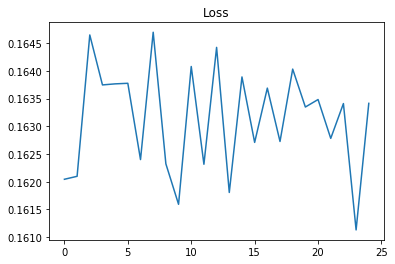

In [13]:
means = []
for l in epoch_losses:
    l = np.array(l)
    l = l[l != None]
    means.append(l.mean())

plt.plot(range(len(epoch_losses)), means)
plt.title('Loss')

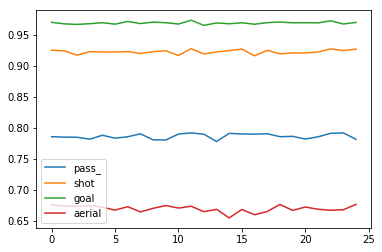

In [14]:
# [epoch#, replay#, hit#, category#]
means = []
for epoch in accuracy:
    epoch = np.asarray(np.asarray(epoch).tolist())
    replay_means = []
    for replay in epoch:
        cat_means = []
        for i, c in enumerate(categories):
            cat_means.append(np.array(replay[:, i].mean()))
        replay_means.append(np.array(cat_means))
    means.append(np.array(replay_means))
means = np.array(means)

for i, c in enumerate(categories):
    data = [means[epoch][:, i].mean() for epoch in range(len(accuracy))]
    plt.plot(data)
plt.legend(categories)
# plt.plot(range(len(accuracy)), means)
# plt.title('Accuracy')
#plt.legend(['Team Accuracy', 'Frame Accuracy']);

In [15]:

input_train, input_test, output_train, output_test = get_train_test_data(proto, df)

In [ ]:
model(torch.from_numpy(input_test).float().cuda())

In [31]:
output_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [32]:
input_test[0]

array([ 1.89757000e+03, -1.09464000e+03,  1.89700000e+02,  5.76413006e-01,
       -2.62186053e-01, -2.39483238e+00, -2.87670000e+03,  2.23726000e+04,
        8.98150000e+03,  4.21830000e+03,  4.24210000e+03,  4.58200000e+02,
        0.00000000e+00,  2.01921000e+03, -1.24901000e+03,  9.47900000e+01,
        6.88463231e-01,  1.76019462e+00, -2.77692741e-01,  2.73780000e+03,
        1.87719000e+04,  1.89070000e+03, -4.55710000e+03, -3.06070000e+03,
        3.37600000e+02,  2.55000000e+02,  1.28000000e+02,             nan,
        1.00000000e+00,  1.47000000e+02,  0.00000000e+00,  6.00000000e+00,
        0.00000000e+00,  5.00000000e+00,  9.00000000e+00,             nan])

# Ensemble

In [32]:
num_columns = 12
class HitPredictorEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 2),
            nn.Softmax()
        )
    
    def forward(self, game_state):
        return self.layers(game_state)

In [4]:
categories = ['aerial', 'pass_', 'shot', 'goal', ]
def get_train_test_data(proto, dataframe):
    
    # Only from the perspective of the blue team (we'll switch them up)
#     players = dataframe.columns.levels[0]
#     columns = dataframe.columns.levels[1]
    players = proto.players
    teams = proto.teams
    team_map = {}
    for i, team in enumerate(teams):
        for player in team.player_ids:
            team_map[player.id] = int(team.is_orange)
            
    name_map = {}
    for i, player in enumerate(players):
        name_map[player.id.id] = player.name
    
    hits = proto.game_stats.hits
    inputs = []
    outputs = []
    for hit in hits:
        player_name = name_map[hit.player_id.id]
        
        frame = dataframe.iloc[hit.frame_number + 1]
        cols = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z']
        player_location = frame[player_name][cols].fillna(-1)
        ball_location = frame['ball'][cols].fillna(-1)
        input_vector = ball_location.values
        input_vector = np.append(input_vector, player_location.values)
        
        inputs.append(input_vector)
        vector = np.zeros(len(categories))
        for i, c in enumerate(categories):
            if getattr(hit, c):
                vector[i] = 1
        outputs.append(vector)
    inputs = np.array(inputs).astype(float)
    outputs = np.array(outputs)
    rand = np.random.rand(outputs.shape[0])
    threshold = rand < 0.8
    input_train, input_test = inputs[threshold], inputs[~threshold]
    output_train, output_test = outputs[threshold], outputs[~threshold]
    
    return input_train, input_test, output_train, output_test


def generate_data():
    input_train_batches, input_test_batches, output_train_batches, output_test_batches = [[], [], [], []]
    for n in range(5):
        for replay in data_manager.get_replay_list(num=200, page=n + 1):
            df = data_manager.get_pandas(replay)
            proto = data_manager.get_proto(replay)
            if df is None or proto is None:
                continue
            #print(proto.game_metadata.match_guid)
            try:
                input_train, input_test, output_train, output_test = get_train_test_data(proto, df)
                input_train_batches.append(input_train)
                input_test_batches.append(input_test)
                output_train_batches.append(output_train)
                output_test_batches.append(output_test)
            except Exception as e:
                print(e)
    return input_train_batches, input_test_batches, output_train_batches, output_test_batches

In [5]:
result = generate_data()

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/carball/analysis/utils/numpy_manager.py", line 36, in read_array_fro

single positional indexer is out-of-bounds


In [33]:

models = {}
epochs = 25
for c in categories:
    m = HitPredictorEnsemble().train()
    
    if cuda:
        m = m.cuda()
    opt = optim.Adam(m.parameters(), lr=1e-3)
    models[c] = (m, opt)

In [34]:
pd.get_dummies([1,2,3])

,1,2,3
0,1,0,0
1,0,1,0
2,0,0,1


In [35]:

# loss = nn.BCELoss()
loss = nn.NLLLoss(weight=torch.tensor([0.1, 1]).cuda())
liveloss = PlotLosses()
for x in range(10000):
    for batch in range(len(result[0])):
        input_train = result[0][batch]
        input_test = result[1][batch]
        output_train = result[2][batch]
        output_test = result[3][batch]
        for i, m in enumerate(list(models.keys())[:1]):
            model_tuple = models[m]
            input_tensor = torch.from_numpy(input_train).float()
            #output_tensor = torch.from_numpy(output_train[:, i].reshape((-1, 1))).float()
            output_tensor = torch.from_numpy(pd.get_dummies(output_train[:, i]).values).long()
            if cuda:
                input_tensor = input_tensor.cuda()
                output_tensor = output_tensor.cuda()
            model_tuple[1].zero_grad()
            predicted = model_tuple[0](input_tensor)
            print(predicted, output_tensor)
            loss_val = loss(predicted, output_tensor)
            loss_val.backward()
            model_tuple[1].step()
            if x % 100 == 0 and batch == 0 and m == 'aerial':
                input_test_tensor = torch.from_numpy(input_test).float()
                if cuda:
                    input_test_tensor = input_test_tensor.cuda()
                test_output = model_tuple[0](input_test_tensor)
                output = test_output.cpu().detach().numpy()
                accuracy = (output.round() == output_test[:, i].reshape((-1, 1)))
                accuracy = accuracy.sum() / accuracy.shape[0]
                liveloss.update({
                    'log loss '+m: loss_val.cpu().detach().numpy(),
                    'accuracy '+m: accuracy,
#                         'val_accuracy': avg_accuracy_val
                })
                liveloss.draw()

tensor([[0.6028, 0.3972],
        [0.3798, 0.6202],
        [0.5870, 0.4130],
        [0.6295, 0.3705],
        [0.4674, 0.5326],
        [0.3273, 0.6727],
        [0.3837, 0.6163],
        [0.2970, 0.7030],
        [0.4618, 0.5382],
        [0.3745, 0.6255],
        [0.6201, 0.3799],
        [0.2958, 0.7042],
        [0.6954, 0.3046],
        [0.4532, 0.5468],
        [0.5739, 0.4261],
        [0.3195, 0.6805],
        [0.3150, 0.6850],
        [0.2819, 0.7181],
        [0.5596, 0.4404],
        [0.4085, 0.5915],
        [0.4800, 0.5200],
        [0.3631, 0.6369],
        [0.3183, 0.6817],
        [0.3416, 0.6584],
        [0.6682, 0.3318],
        [0.6488, 0.3512],
        [0.6530, 0.3470],
        [0.3216, 0.6784],
        [0.5594, 0.4406],
        [0.5061, 0.4939],
        [0.5980, 0.4020],
        [0.5996, 0.4004],
        [0.5902, 0.4098],
        [0.3316, 0.6684],
        [0.3830, 0.6170],
        [0.3308, 0.6692],
        [0.5371, 0.4629],
        [0.4150, 0.5850],
        [0.5

/home/matthew/PycharmProjects/ReplayML/venv/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


RuntimeError: multi-target not supported at /pytorch/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15